In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# from datasets import load_dataset

dataset =  pd.read_csv("hf://datasets/VikramJi/patent-classification/train.csv")

# Take a quick look at the data
dataset.head()



label                                               text
0      2  second counting input 5 2 which receives inter...
1      4  extremely low temperature of the chips in cold...
2      3  of the basic ammonium salt of the carboxyl ate...
3      9  18 u2033 is provided which is axially supporte...
4      2  to an u201c inner surface u201d means the surf...

In [3]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59119 entries, 0 to 59118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   59119 non-null  int64 
 1   text    59119 non-null  object
dtypes: int64(1), object(1)
memory usage: 923.9+ KB
None


In [4]:
# Explore the target variable (class)
print("Unique classes:", dataset['label'].unique())
print("Class distribution:")
print(dataset['label'].value_counts())

Unique classes: [2 4 3 9 7 5 6 8 1]
Class distribution:
label
7    7143
8    7102
6    6887
2    6816
1    6756
5    6467
3    6059
9    5961
4    5928
Name: count, dtype: int64


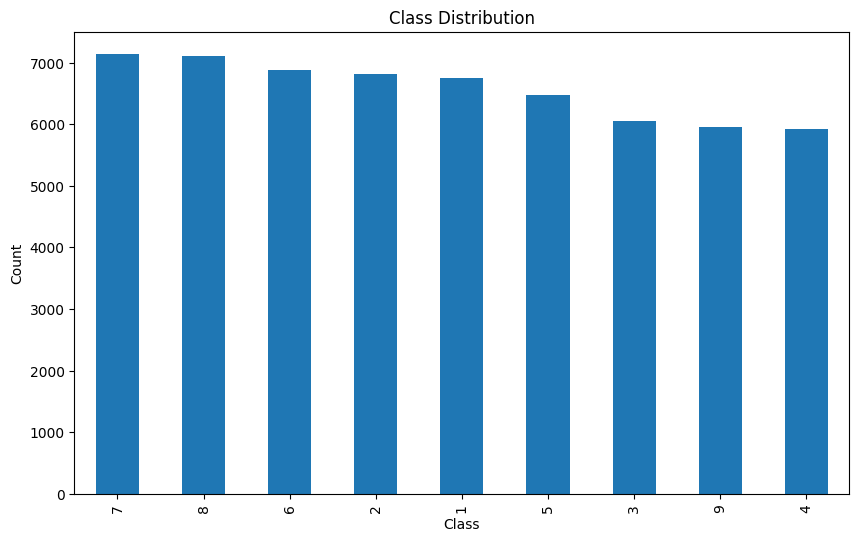

In [5]:
# Visualize the class distribution
plt.figure(figsize=(10, 6))
dataset['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [6]:
# Explore the text data
# print("Average title length:", dataset['title'].str.len().mean())
print("Average abstract length:", dataset['text'].str.len().mean())

Average abstract length: 1412.8042253759368


In [7]:
# Explore the most common words in titles and abstracts
# title_words = ' '.join(dataset['title']).split()
abstract_words = ' '.join(dataset['text']).split()

# print("Most common words in titles:")
# print(Counter(title_words).most_common(10))

print("Most common words in abstracts:")
print(Counter(abstract_words).most_common(10))

Most common words in abstracts:
[('the', 1296263), ('of', 527232), ('a', 434794), ('and', 353513), ('to', 346773), ('in', 304048), ('is', 281400), ('be', 133583), ('as', 120862), ('or', 107788)]


In [8]:
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from tqdm import tqdm

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Create a balanced sample
def create_balanced_sample(dataset, n_samples=100):
    """Create a balanced sample with n_samples from each class"""
    sampled_df = pd.DataFrame()
    for label in dataset['label'].unique():
        label_df = dataset[dataset['label'] == label]
        # If there are fewer samples than requested, take all of them
        n = min(n_samples, len(label_df))
        sampled_df = pd.concat([sampled_df, label_df.sample(n)])
    return sampled_df.reset_index(drop=True)

# Create balanced sample
sample_df = create_balanced_sample(dataset, n_samples=100)
print(f"Sample size: {len(sample_df)} documents")

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Combine stopwords
stop_words = set(stopwords.words('english'))
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS
all_stop_words = stop_words.union(spacy_stop_words)

# Add custom technical stopwords
technical_stop_words = {'fig', 'figure', 'wherein', 'thereof', 'comprising', 
                       'comprises', 'claimed', 'claim', 'preferably'}
all_stop_words.update(technical_stop_words)

def preprocess_text(text):
    # Convert to lowercase and process with spaCy
    doc = nlp(text.lower())
    
    # Remove stop words, punctuation, numbers and short words
    tokens = [token.lemma_ for token in doc 
             if token.lemma_ not in all_stop_words
             and not token.is_punct
             and not token.like_num
             and len(token.lemma_) > 2]
    
    return " ".join(tokens)

# Process texts with progress bar
print("Preprocessing texts...")
tqdm.pandas()
sample_df['processed_text'] = sample_df['text'].progress_apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Sample size: 900 documents
Preprocessing texts...


100%|██████████| 900/900 [00:31<00:00, 28.41it/s]


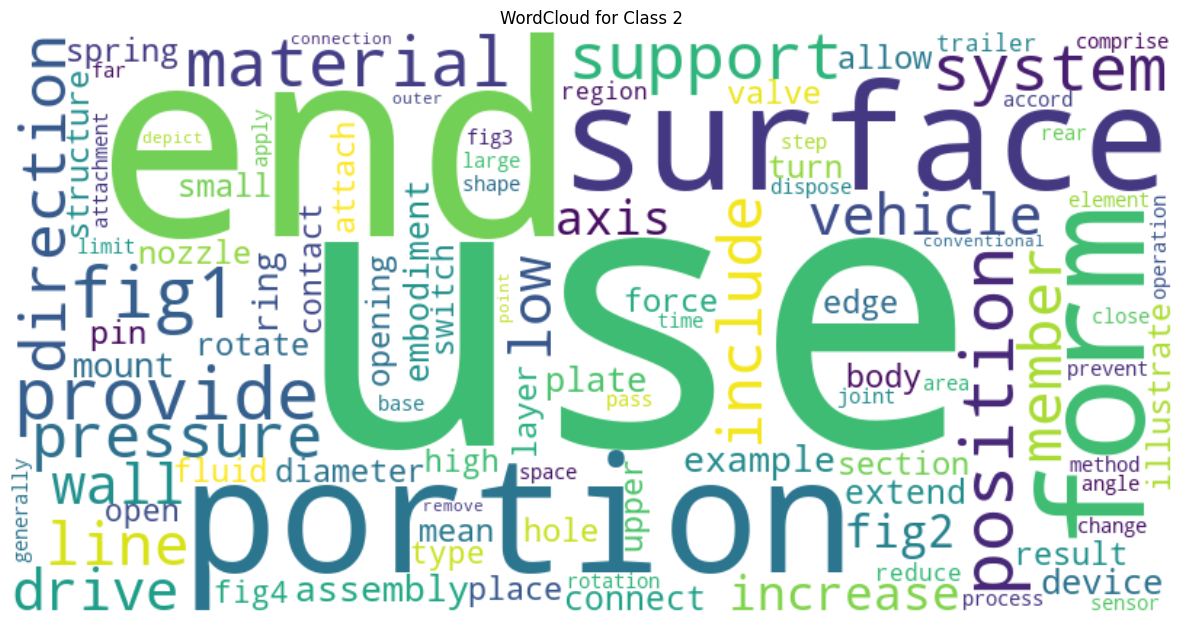

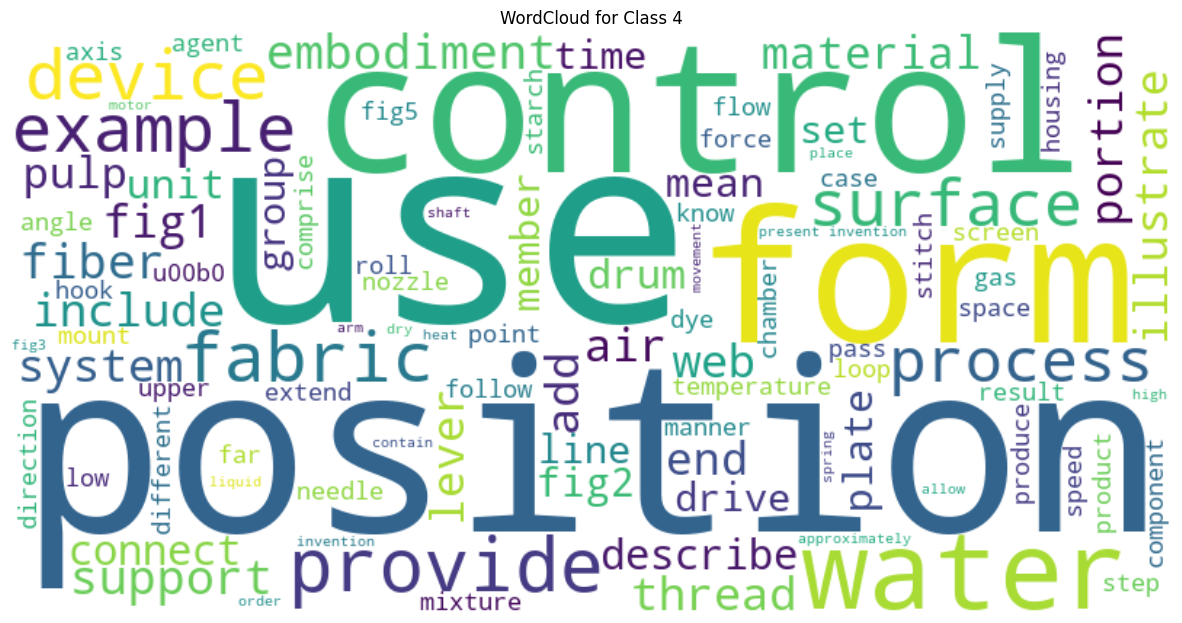

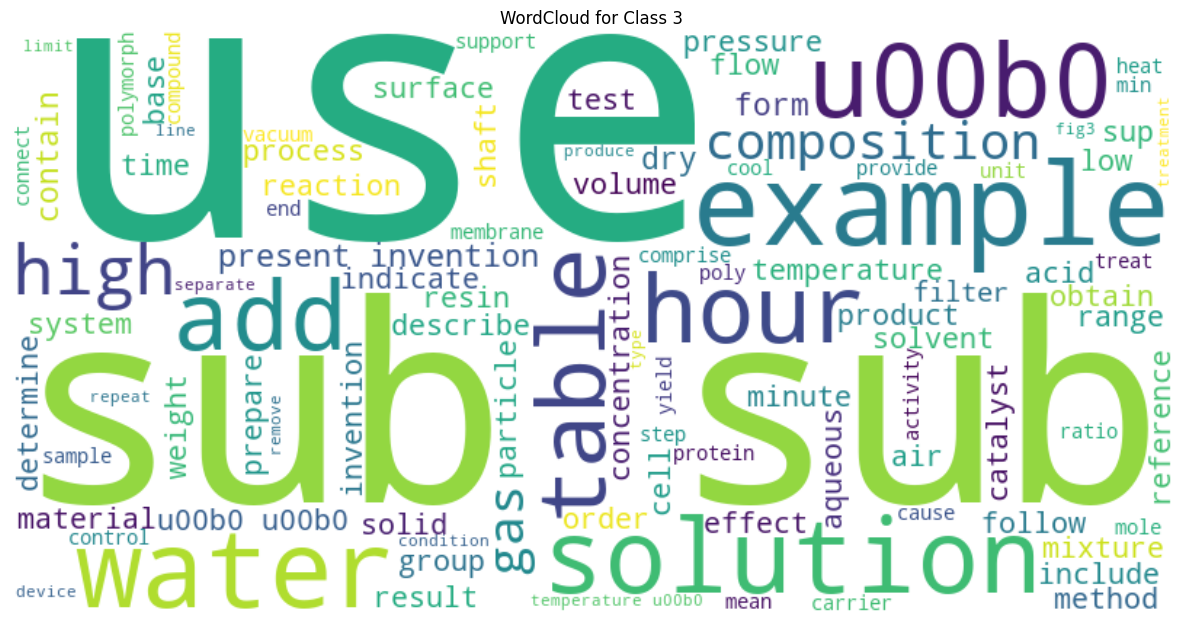

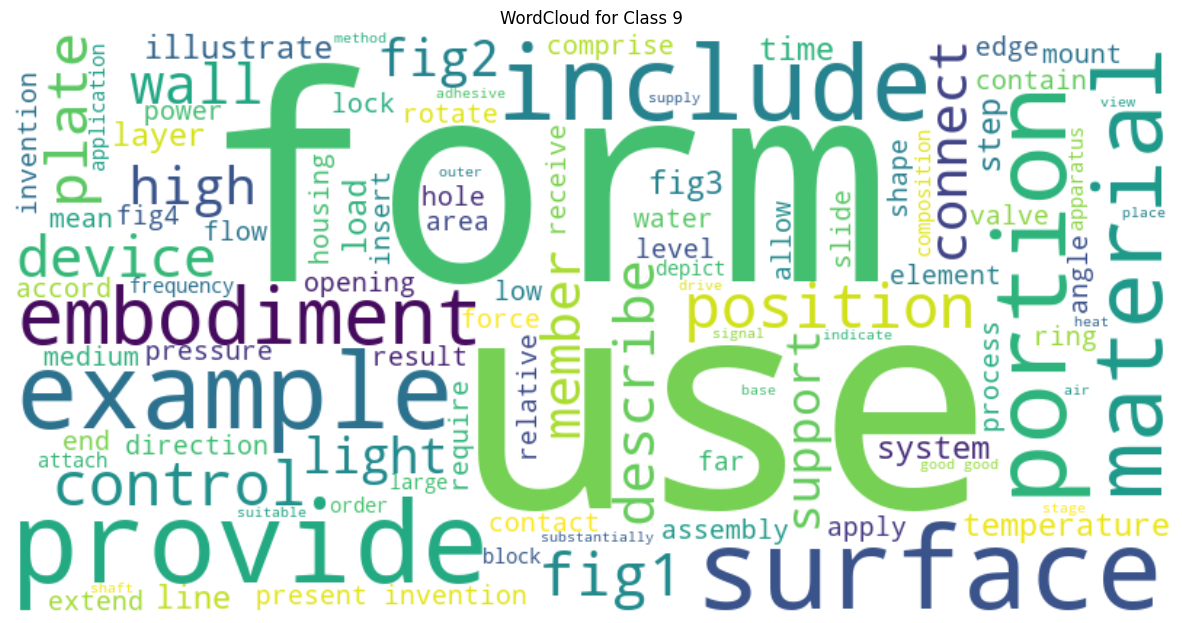

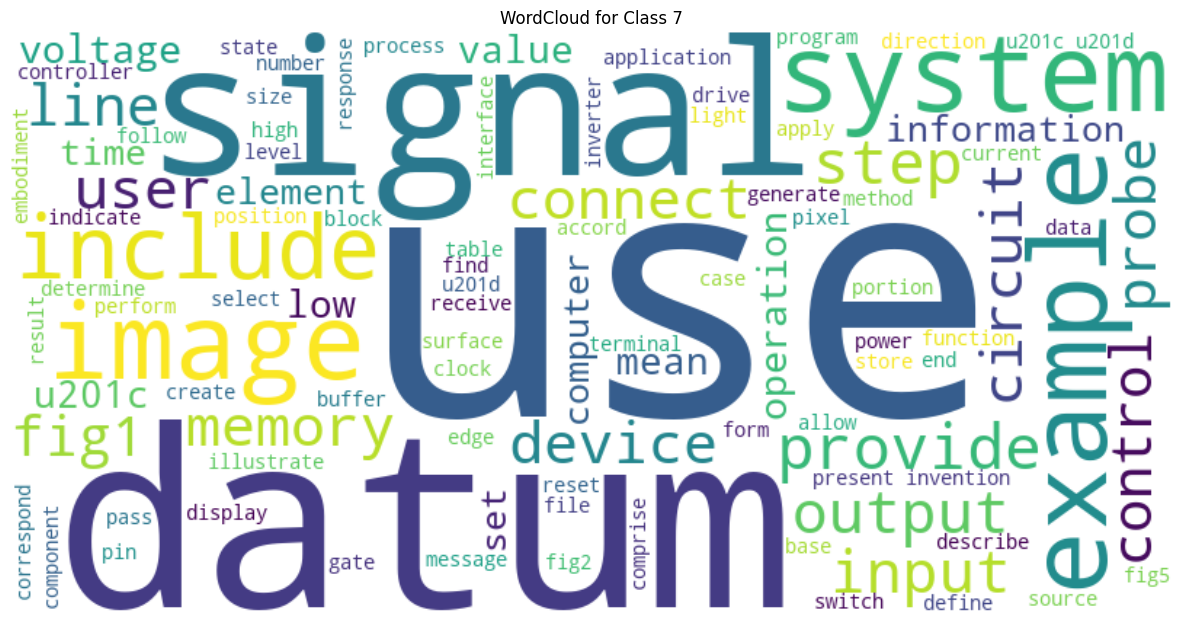

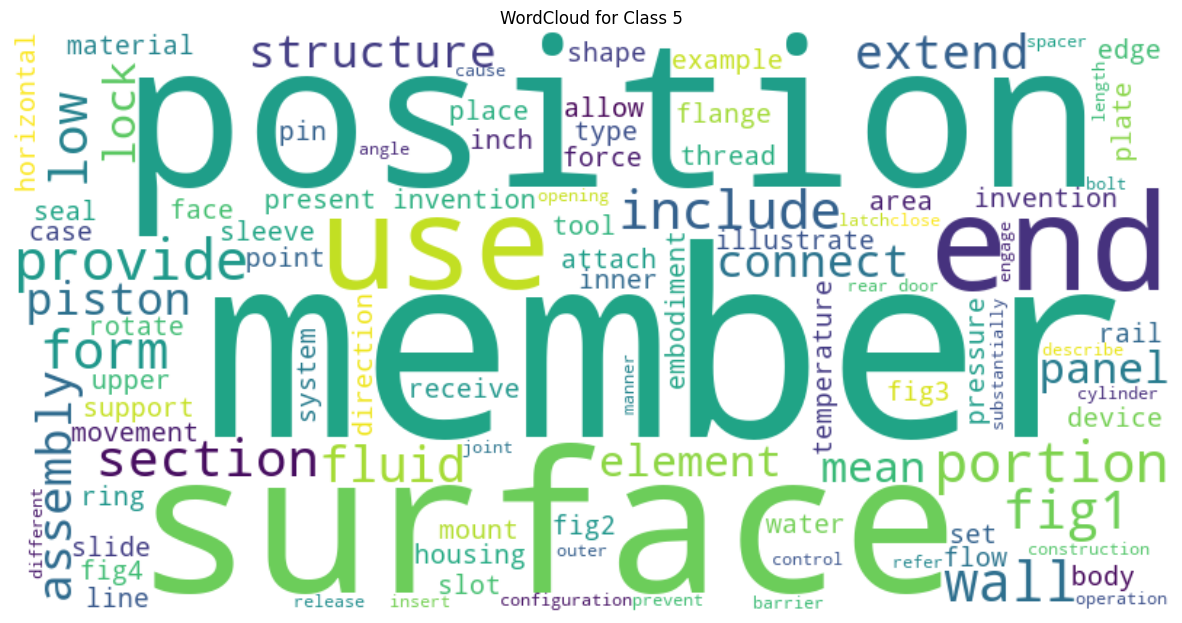

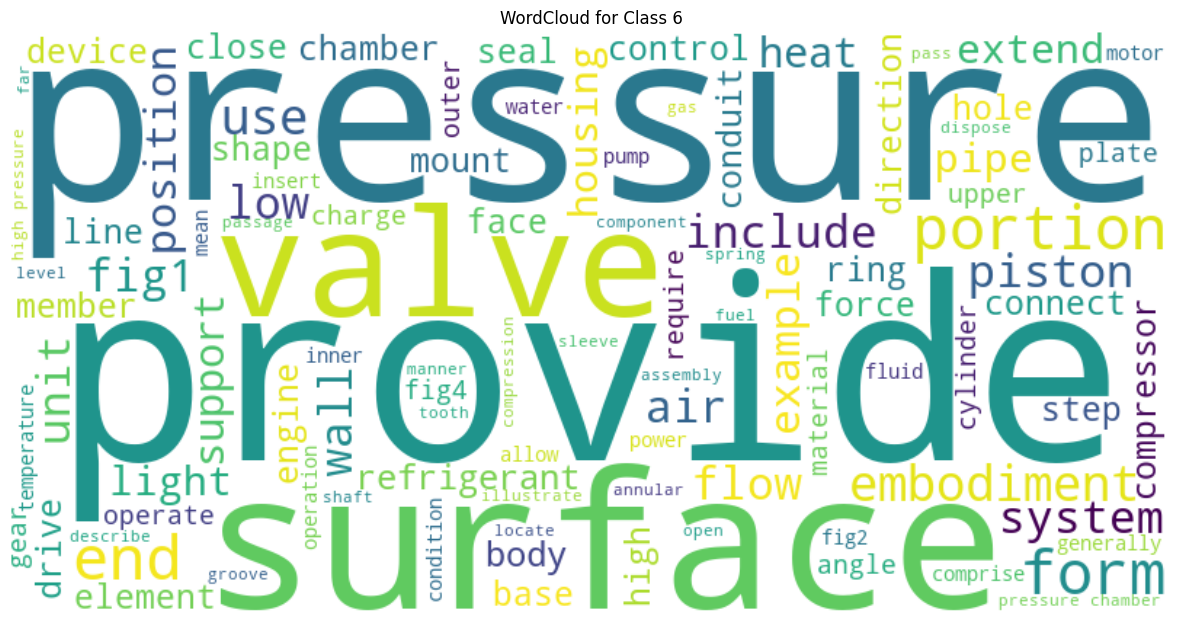

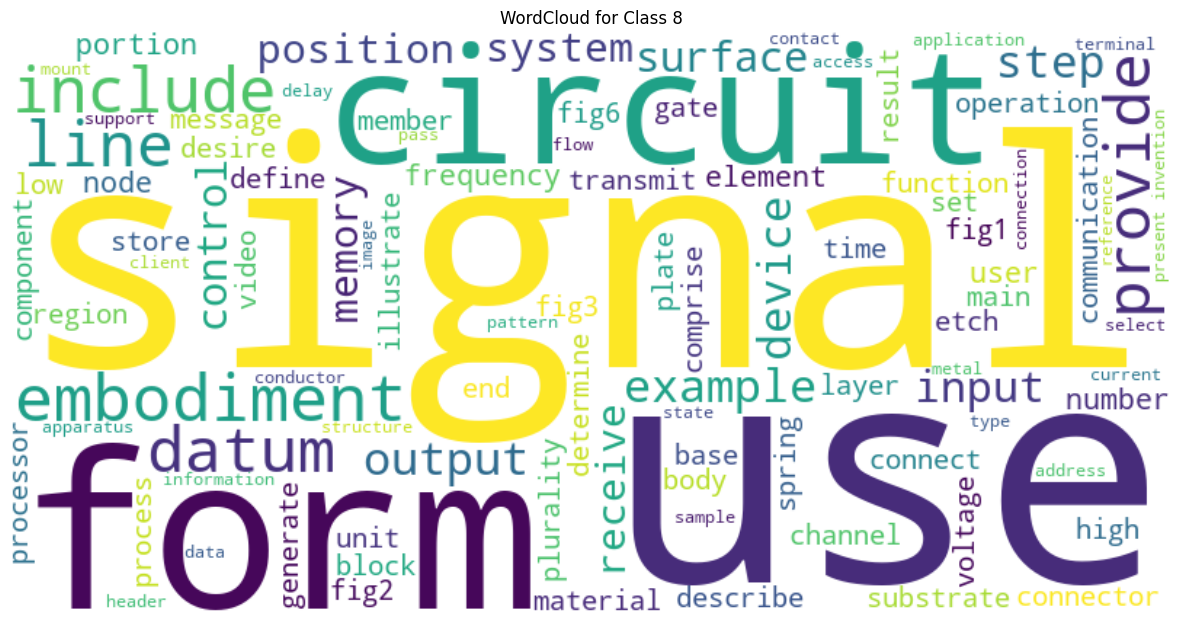

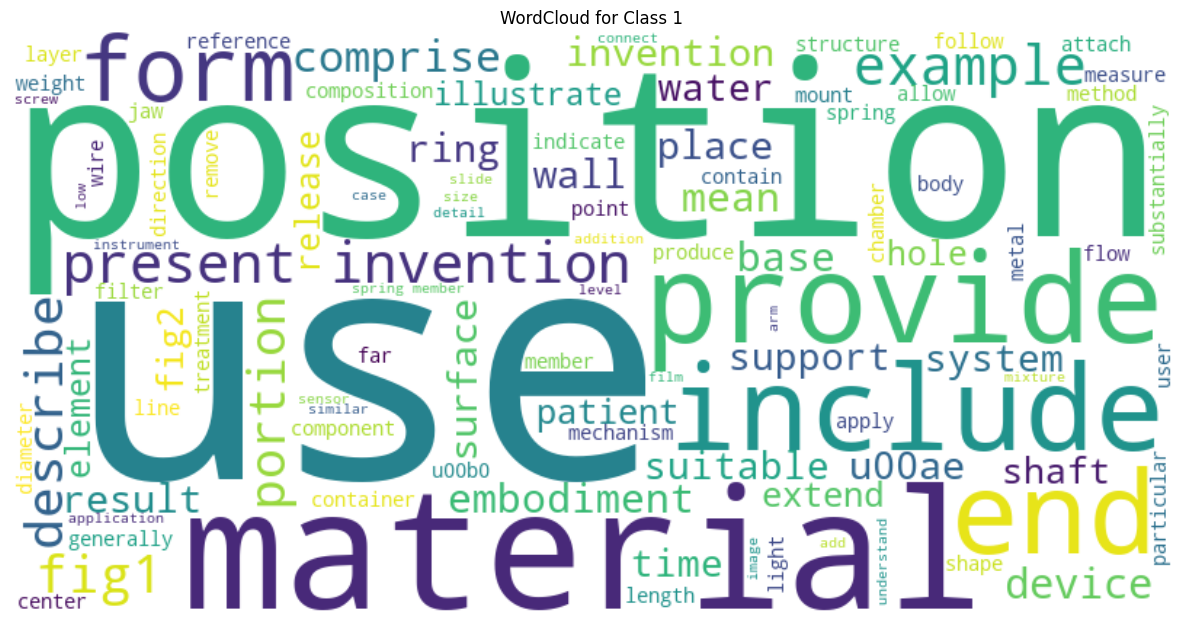

In [9]:
# Generate WordCloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text)
    
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate class-specific wordclouds
for label in sample_df['label'].unique():
    class_text = " ".join(sample_df[sample_df['label'] == label]['processed_text'])
    generate_wordcloud(class_text, f'WordCloud for Class {label}')

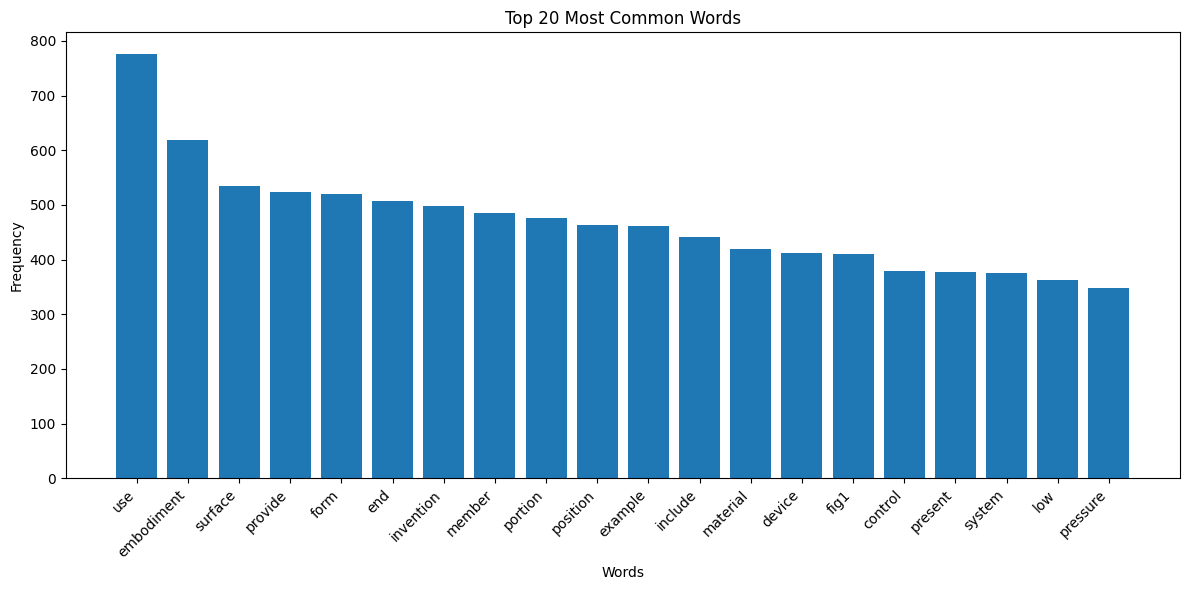

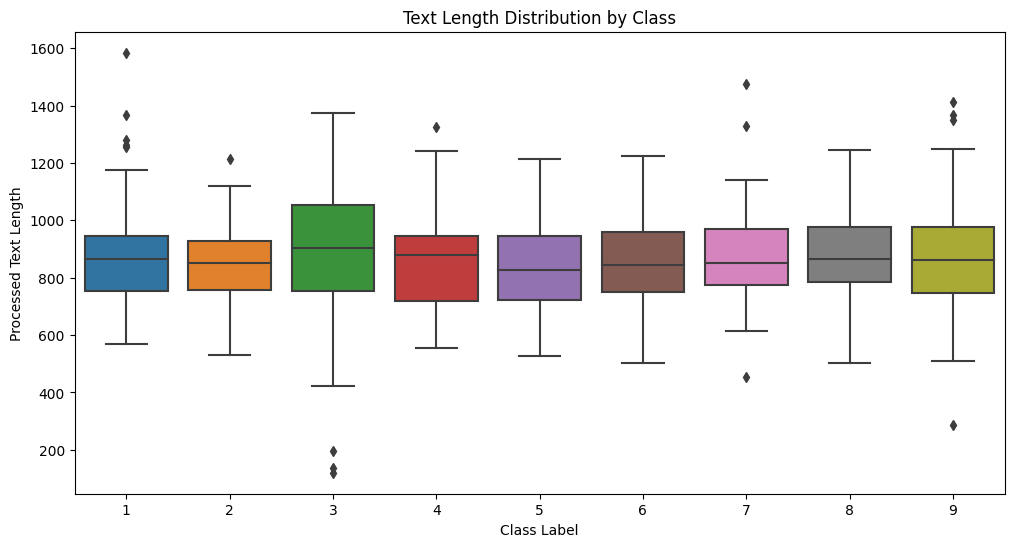


Most common terms and their frequencies:
use: 777
embodiment: 619
surface: 535
provide: 524
form: 521
end: 507
invention: 498
member: 485
portion: 477
position: 464
example: 461
include: 442
material: 420
device: 412
fig1: 410
control: 380
present: 377
system: 376
low: 362
pressure: 348


In [10]:
# Word frequency analysis
all_text = " ".join(sample_df['processed_text'])
word_freq = Counter(all_text.split()).most_common(20)

# Plot word frequency
plt.figure(figsize=(12, 6))
words, freqs = zip(*word_freq)
plt.bar(words, freqs)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Text length distribution
sample_df['text_length'] = sample_df['processed_text'].str.len()
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='text_length', data=sample_df)
plt.title('Text Length Distribution by Class')
plt.xlabel('Class Label')
plt.ylabel('Processed Text Length')
plt.show()

# Print summary statistics
print("\nMost common terms and their frequencies:")
for word, freq in word_freq:
    print(f"{word}: {freq}")